# Initial Set-Up Work:

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [134]:
df = pd.read_csv("LeagueofLegends.csv")
df.head()


,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redMiddleChamp,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,Fizz,"[475, 475, 552, 842, 1178, 1378, 1635, 1949, 2...",Sneaky,Sivir,"[475, 475, 532, 762, 1097, 1469, 1726, 2112, 2...",LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,Azir,"[475, 475, 552, 786, 1097, 1389, 1660, 1955, 2...",CoreJJ,Corki,"[475, 475, 532, 868, 1220, 1445, 1732, 1979, 2...",KiWiKiD,Annie,"[515, 515, 583, 752, 900, 1066, 1236, 1417, 15...","['RekSai', 'Janna', 'Leblanc']",http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,Azir,"[475, 475, 533, 801, 1006, 1233, 1385, 1720, 1...",Cop,Corki,"[475, 475, 533, 781, 1085, 1398, 1782, 1957, 2...",BunnyFuFuu,Janna,"[515, 515, 584, 721, 858, 1002, 1168, 1303, 14...","['Leblanc', 'Zed', 'RekSai']",http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,Lulu,"[475, 475, 532, 771, 1046, 1288, 1534, 1776, 2...",KEITH,KogMaw,"[475, 475, 532, 766, 1161, 1438, 1776, 1936, 2...",Xpecial,Janna,"[515, 515, 583, 721, 870, 1059, 1205, 1342, 15...","['RekSai', 'Rumble', 'LeeSin']",http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,Lulu,"[475, 475, 532, 807, 1042, 1338, 1646, 1951, 2...",Maplestreet8,Corki,"[475, 475, 532, 792, 1187, 1488, 1832, 2136, 2...",Dodo8,Annie,"[475, 475, 538, 671, 817, 948, 1104, 1240, 136...","['Rumble', 'Sivir', 'Rengar']",http://matchhistory.na.leagueoflegends.com/en/...


# Data Preprocessing:

In [138]:
df = df.sort_values(by=["Address"])
blue_team_composition_df = df.filter(["Address","blueTopChamp","blueMiddleChamp", "blueADCChamp", "blueSupportChamp", "blueJungleChamp"])
blue_team_composition_df.head()

,Address,blueTopChamp,blueMiddleChamp,blueADCChamp,blueSupportChamp,blueJungleChamp
4357,http://matchhistory.br.leagueoflegends.com/pt/...,Renekton,Galio,Xayah,Taric,JarvanIV
4359,http://matchhistory.br.leagueoflegends.com/pt/...,Renekton,Galio,Varus,Rakan,Gragas
4360,http://matchhistory.br.leagueoflegends.com/pt/...,JarvanIV,Syndra,Xayah,Rakan,Sejuani
4361,http://matchhistory.br.leagueoflegends.com/pt/...,JarvanIV,Lucian,Xayah,Shen,Sejuani
4363,http://matchhistory.br.leagueoflegends.com/pt/...,JarvanIV,Taliyah,Twitch,Braum,RekSai


In [118]:
red_team_composition_df = df.filter(["Address","redTopChamp","redMiddleChamp", "redADCChamp", "redSupportChamp", "redJungleChamp"])
red_team_composition_df.head()

,Address,redTopChamp,redMiddleChamp,redADCChamp,redSupportChamp,redJungleChamp
4357,http://matchhistory.br.leagueoflegends.com/pt/...,Shen,Corki,Tristana,Lulu,Gragas
4359,http://matchhistory.br.leagueoflegends.com/pt/...,Chogath,Malzahar,Xayah,Alistar,JarvanIV
4360,http://matchhistory.br.leagueoflegends.com/pt/...,Camille,Taliyah,Kalista,Morgana,Gragas
4361,http://matchhistory.br.leagueoflegends.com/pt/...,Poppy,Cassiopeia,Tristana,Braum,Elise
4363,http://matchhistory.br.leagueoflegends.com/pt/...,Chogath,Lucian,Varus,Lulu,Gragas


In [119]:
df.drop(['League', 'Season', 'Type', 'blueTeamTag', 'goldblueTop', 'goldblueJungle', 'goldblueMiddle', 
         'goldblueADC', 'goldblueSupport', 'redTop', 'goldredTop', 'redJungle', 'goldredJungle', 
         'redMiddle', 'goldredMiddle', 'redADC', 'goldredADC', 'redSupport', 'goldredSupport', 'redTeamTag', 
         'blueTop', 'blueMiddle', 'blueJungle', 'blueADC', 'blueSupport'], axis=1, inplace=True)

In [120]:
df.columns

Index(['Year', 'bResult', 'rResult', 'gamelength', 'golddiff', 'goldblue',
       'bKills', 'bTowers', 'bInhibs', 'bDragons', 'bBarons', 'bHeralds',
       'goldred', 'rKills', 'rTowers', 'rInhibs', 'rDragons', 'rBarons',
       'rHeralds', 'blueTopChamp', 'blueJungleChamp', 'blueMiddleChamp',
       'blueADCChamp', 'blueSupportChamp', 'blueBans', 'redTopChamp',
       'redJungleChamp', 'redMiddleChamp', 'redADCChamp', 'redSupportChamp',
       'redBans', 'Address'],
      dtype='object')

In [121]:
df.isnull().sum()

Year                0
bResult             0
rResult             0
gamelength          0
golddiff            0
goldblue            0
bKills              0
bTowers             0
bInhibs             0
bDragons            0
bBarons             0
bHeralds            0
goldred             0
rKills              0
rTowers             0
rInhibs             0
rDragons            0
rBarons             0
rHeralds            0
blueTopChamp        0
blueJungleChamp     0
blueMiddleChamp     0
blueADCChamp        0
blueSupportChamp    0
blueBans            0
redTopChamp         0
redJungleChamp      0
redMiddleChamp      0
redADCChamp         0
redSupportChamp     0
redBans             0
Address             0
dtype: int64

<AxesSubplot:title={'center':'gamelength'}, ylabel='Frequency'>

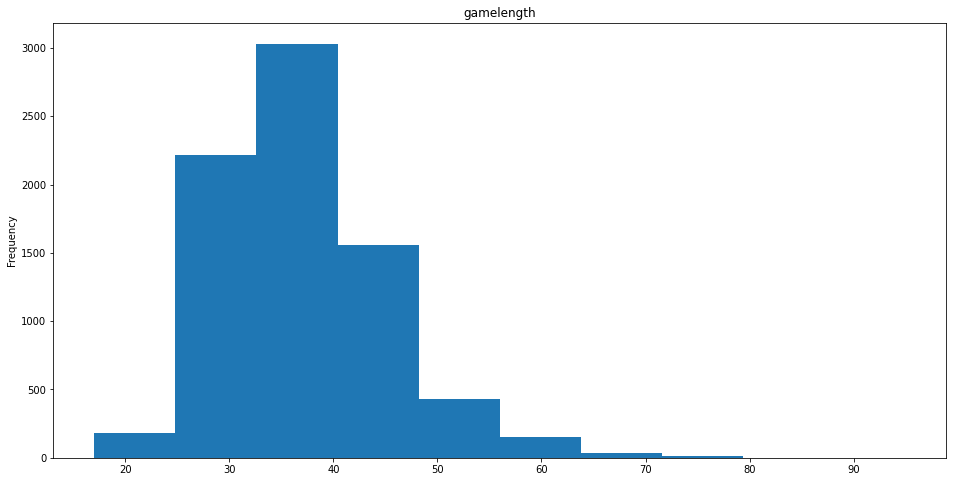

In [122]:
plt.figure('gamelength', figsize=(16,8))
plt.title('gamelength')
df['gamelength'].plot(kind='hist')

In [123]:
df.describe()['gamelength']

count    7620.000000
mean       37.012598
std         7.983238
min        17.000000
25%        31.000000
50%        36.000000
75%        41.000000
max        95.000000
Name: gamelength, dtype: float64

In [124]:
def find_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3-q1
    outliers = df[((df[col] < (q1 - 1.5*IQR)) | (df[col] > (q3 + 1.5*IQR)))]
    return outliers

In [125]:
outliers = find_outliers(df, 'gamelength').index
print(outliers)

Int64Index([4286, 4289, 4241, 4249, 4257, 4092, 4104, 4117, 4122, 4123,
            ...
            6338, 6381, 6389, 6136, 4489, 4723, 4597, 7059, 7570, 7068],
           dtype='int64', length=164)


In [126]:
df = df.drop(outliers)

In [127]:
print(df)

      Year  bResult  rResult  gamelength  \
4357  2017        1        0          34   
4359  2017        0        1          45   
4360  2017        1        0          42   
4361  2017        0        1          27   
4363  2017        1        0          37   
...    ...      ...      ...         ...   
7563  2018        1        0          28   
7564  2018        1        0          43   
7565  2018        1        0          31   
7566  2018        0        1          42   
7567  2018        1        0          35   

                                               golddiff  \
4357  [0, 0, 0, 169, 42, 45, 232, -182, -82, -33, 20...   
4359  [0, 0, 107, -386, -796, -822, -885, -1082, -10...   
4360  [0, 0, -17, -55, -81, 21, 744, 428, 656, 653, ...   
4361  [0, 0, -7, -145, -326, -278, -628, -1024, -944...   
4363  [0, 0, 11, 103, -230, -249, -775, -325, -324, ...   
...                                                 ...   
7563  [0, 0, -100, 169, 372, 399, 567, 466, 627, 486...   

In [128]:
df.describe()

,Year,bResult,rResult,gamelength
count,7456.000000,7456.000000,7456.000000,7456.000000
mean,2016.282591,0.543723,0.456277,36.458423
std,0.847736,0.498118,0.498118,7.078681
min,2014.000000,0.000000,0.000000,17.000000
25%,2016.000000,0.000000,0.000000,31.000000
50%,2016.000000,1.000000,0.000000,36.000000
75%,2017.000000,1.000000,1.000000,41.000000
max,2018.000000,1.000000,1.000000,56.000000


In [14]:
killdf = pd.read_csv("kills.csv")

In [15]:
kills = killdf.groupby(["Address", "Team"]).size().reset_index(name = "Kills")

In [16]:
kills

,Address,Team,Kills
0,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,6
1,http://matchhistory.br.leagueoflegends.com/pt/...,rKills,1
2,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,22
3,http://matchhistory.br.leagueoflegends.com/pt/...,rKills,19
4,http://matchhistory.br.leagueoflegends.com/pt/...,bKills,11
...,...,...,...
15235,https://matchhistory.na.leagueoflegends.com/en...,rKills,1
15236,https://matchhistory.na.leagueoflegends.com/en...,bKills,2
15237,https://matchhistory.na.leagueoflegends.com/en...,rKills,14
15238,https://matchhistory.na.leagueoflegends.com/en...,bKills,11


In [17]:
bKills = kills[kills['Team'] == 'bKills']
rKills = kills[kills['Team'] == 'rKills']

In [18]:
print(df.loc[(df['Address'] == 'http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/30030?gameHash=fbb300951ad8327c'), 'bKills'])

0    [[10.82, 'C9 Hai', 'TSM Bjergsen', [], 9229, 8...
Name: bKills, dtype: object


In [19]:
for row in bKills.index:
    addr = bKills.loc[row, 'Address']
    df.loc[(df['Address'] == addr), 'bKills'] = bKills.loc[row, 'Kills']

In [20]:
print(df[['Address', 'bKills']])

                                                Address bKills
0     http://matchhistory.na.leagueoflegends.com/en/...     16
1     http://matchhistory.na.leagueoflegends.com/en/...     10
2     http://matchhistory.na.leagueoflegends.com/en/...     22
3     http://matchhistory.na.leagueoflegends.com/en/...     10
4     http://matchhistory.na.leagueoflegends.com/en/...     22
...                                                 ...    ...
7615  https://matchhistory.euw.leagueoflegends.com/e...      7
7616  https://matchhistory.euw.leagueoflegends.com/e...      8
7617  https://matchhistory.na.leagueoflegends.com/en...      5
7618  https://matchhistory.na.leagueoflegends.com/en...     16
7619  https://matchhistory.na.leagueoflegends.com/en...     12

[7456 rows x 2 columns]


In [21]:
for row in rKills.index:
    addr = rKills.loc[row, 'Address']
    df.loc[(df['Address'] == addr), 'rKills'] = rKills.loc[row, 'Kills']

In [22]:
print(df[['Address', 'bKills', 'rKills']])

                                                Address bKills rKills
0     http://matchhistory.na.leagueoflegends.com/en/...     16      9
1     http://matchhistory.na.leagueoflegends.com/en/...     10      9
2     http://matchhistory.na.leagueoflegends.com/en/...     22      8
3     http://matchhistory.na.leagueoflegends.com/en/...     10     21
4     http://matchhistory.na.leagueoflegends.com/en/...     22     10
...                                                 ...    ...    ...
7615  https://matchhistory.euw.leagueoflegends.com/e...      7     16
7616  https://matchhistory.euw.leagueoflegends.com/e...      8     18
7617  https://matchhistory.na.leagueoflegends.com/en...      5     13
7618  https://matchhistory.na.leagueoflegends.com/en...     16      2
7619  https://matchhistory.na.leagueoflegends.com/en...     12     23

[7456 rows x 3 columns]
